## SETUP

In this section, I import the Python libraries that I use throughout the
analysis for data manipulation, visualization, and statistical testing

In [ ]:
# @author: beyzacesur

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Loading/ 2. Time Columns/ 3. Last 3 Months

In this step, the TikTok activity data is imported from a JSON file and converted
into a pandas DataFrame. Time-related features are extracted from the event
timestamps, and the dataset is filtered to include only the last three months
of activity for analyzing recent usage behavior.


In [ ]:
# =============================
# 1-) IMPORT

json_path = "user_data_tiktok.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

events_list = data["Ads and data"]["Off TikTok Activity"]["OffTikTokActivityDataList"]
df = pd.DataFrame(events_list)


# =============================
# 2) TIME COLUMNS

df["timestamp"] = pd.to_datetime(df["TimeStamp"])
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["day_of_week"] >= 5

# =============================
# 3) LAST 3 MONTHS

son_tarih = df["timestamp"].max()
uc_ay_once = son_tarih - pd.DateOffset(months=3)
df_tiktok = df[df["timestamp"] >= uc_ay_once].copy()

### 4. Defining Time Periods

Each event is assigned to one of three predefined 8-hour periods:
morning (05:00–12:59), afternoon (13:00–20:59), or night (21:00–04:59).
This classification is used to analyze daily usage distribution across
different parts of the day.

In [ ]:
# =============================
# 4) 8 HOUR- PERIODS

def assign_period(hour: int) -> str:
    if 5 <= hour <= 12:
        return "morning"
    elif 13 <= hour <= 20:
        return "afternoon"
    else:
        return "night"

df_tiktok["period"] = df_tiktok["hour"].apply(assign_period)

### 5. Daily Aggregation and Usage Metrics

Daily event counts are computed separately for morning, afternoon, and night.
From these counts, total daily activity and usage ratios are calculated.

Since actual watch time is not available, a proxy usage duration is defined
by assuming a fixed number of minutes per event. These proxy values are used
only for relative comparisons, not as true screen time measurements.

In [ ]:
# =============================
# 5) NUMBER OF EVENTS IN EACH DAY

daily = (
    df_tiktok
    .groupby(["date", "period"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

for col in ["morning", "afternoon", "night"]:
    if col not in daily.columns:
        daily[col] = 0

daily["total_events"] = daily["morning"] + daily["afternoon"] + daily["night"]

denom = daily["total_events"].where(daily["total_events"] != 0, np.nan)
daily["morning_ratio"] = daily["morning"] / denom
daily["afternoon_ratio"] = daily["afternoon"] / denom
daily["night_ratio"] = daily["night"] / denom

# PROXY TIME

MINUTES_PER_EVENT = 5
daily["morning_minutes_proxy"] = daily["morning"] * MINUTES_PER_EVENT
daily["afternoon_minutes_proxy"] = daily["afternoon"] * MINUTES_PER_EVENT
daily["night_minutes_proxy"] = daily["night"] * MINUTES_PER_EVENT
daily["total_minutes_proxy"] = daily["total_events"] * MINUTES_PER_EVENT

### 6. Center of Activity Hour

To identify the dominant activity time within each day, a circular mean of
activity hours is calculated. This approach correctly accounts for the cyclical
nature of time, where late night and early morning hours are close to each other.

In [ ]:
# =============================
# 6) CENTER OF ACTIVITY HOUR

def circular_mean_hour(hours: np.ndarray) -> float:
    if len(hours) == 0:
        return np.nan
    radians = np.deg2rad(hours * 15)
    sin_sum = np.sin(radians).sum()
    cos_sum = np.cos(radians).sum()
    mean_angle = np.arctan2(sin_sum, cos_sum)
    if mean_angle < 0:
        mean_angle += 2 * np.pi
    return np.rad2deg(mean_angle) / 15.0

center_hours = (
    df_tiktok
    .groupby("date")["hour"]
    .apply(lambda x: circular_mean_hour(x.values))
    .reset_index(name="center_of_activity_hour")
)

weekend_info = (
    df_tiktok
    .groupby("date")["is_weekend"]
    .max()
    .reset_index()
)

daily_features = (
    daily
    .merge(center_hours, on="date", how="left")
    .merge(weekend_info, on="date", how="left")
)

print(daily_features.head(10))
print("\nSon 3 ay tarih aralığı:",
      daily_features['date'].min(), "→", daily_features['date'].max())

         date  afternoon  morning  night  total_events  morning_ratio  \
0  2025-08-27          8        7      0            15       0.466667   
1  2025-08-29          4        1      0             5       0.200000   
2  2025-08-30          2        1      0             3       0.333333   
3  2025-08-31          2        0      0             2       0.000000   
4  2025-09-01          2        1      0             3       0.333333   
5  2025-09-03          0        1      0             1       1.000000   
6  2025-09-04          1        2      0             3       0.666667   
7  2025-09-05          3        2      0             5       0.400000   
8  2025-09-06          3        5      0             8       0.625000   
9  2025-09-08          3        1      0             4       0.250000   

   afternoon_ratio  night_ratio  morning_minutes_proxy  \
0         0.533333          0.0                     35   
1         0.800000          0.0                      5   
2         0.666667    

## 7. EXPLORATORY DATA ANALYSIS (EDA)

This section explores temporal patterns in TikTok usage using daily and
period-based features. Visualizations are used to identify trends, variability,
and potential differences across time periods.

### 7.1 Daily TikTok Usage Intensity

The figure illustrates daily TikTok usage intensity measured in proxy minutes
over the last three months. Usage levels vary substantially across days, with
multiple sharp spikes indicating periods of unusually high activity. The lack
of a smooth or repeating pattern suggests irregular usage behavior rather than
a consistent daily routine.

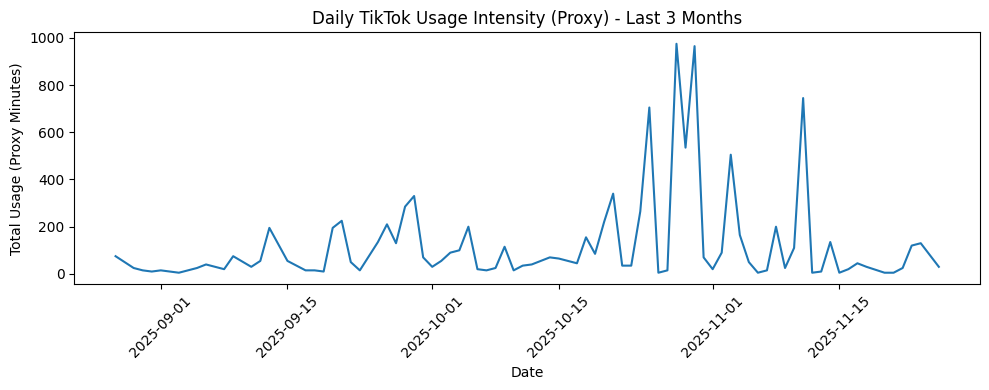

In [ ]:
# =============================
# 7) EDA GRAPHS


# 7.1 TOTAL DAILY USAGE
plt.figure(figsize=(10, 4))
plt.plot(daily_features["date"], daily_features["total_minutes_proxy"])
plt.xlabel("Date")
plt.ylabel("Total Usage (Proxy Minutes)")
plt.title("Daily TikTok Usage Intensity (Proxy) - Last 3 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.2 Average TikTok Usage by Time Period

This bar chart compares the average TikTok usage intensity across three daily
time periods: morning, afternoon, and night, using proxy minutes.
The results indicate that average TikTok usage is highest during the **morning**
period, followed by the afternoon, while night usage is substantially lower.
This suggests that TikTok activity tends to concentrate earlier in the day
rather than late at night. Overall, the pattern points to a more daytime-oriented
usage behavior.

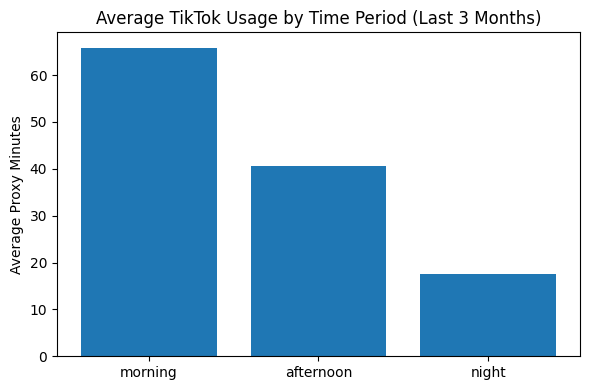

In [ ]:
# 7.2 AVERAGE USAGE BY PERIODS
period_means = {
    "morning": daily_features["morning_minutes_proxy"].mean(),
    "afternoon": daily_features["afternoon_minutes_proxy"].mean(),
    "night": daily_features["night_minutes_proxy"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(period_means.keys(), period_means.values())
plt.ylabel("Average Proxy Minutes")
plt.title("Average TikTok Usage by Time Period (Last 3 Months)")
plt.tight_layout()
plt.show()

### 7.3 Average Usage Ratio by Time Period

This figure shows the average share of daily TikTok usage across morning,
afternoon, and night periods over the last three months. Usage ratios are used
to compare time-of-day preferences independently of total daily activity.

The results indicate that TikTok usage is mostly concentrated in the morning
and afternoon, with the afternoon having a slightly higher share. Night usage
represents a relatively small portion of total activity, suggesting a
day oriented usage pattern rather than a night oriented one.

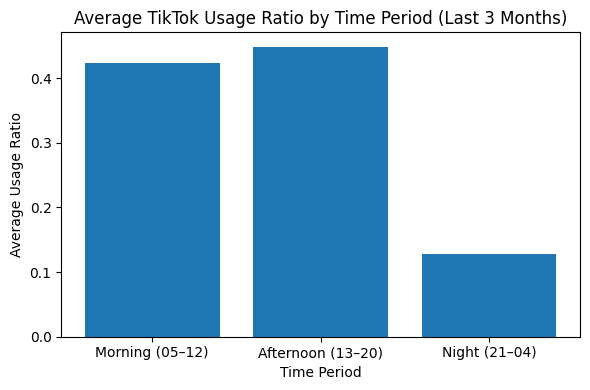

In [ ]:
# 7.3 AVERAGE RATIO FOR EACH PERIOD
period_ratios = {
    "Morning (05–12)": daily_features["morning_ratio"].mean(),
    "Afternoon (13–20)": daily_features["afternoon_ratio"].mean(),
    "Night (21–04)": daily_features["night_ratio"].mean(),
}

plt.figure(figsize=(6, 4))
plt.bar(period_ratios.keys(), period_ratios.values())
plt.ylabel("Average Usage Ratio")
plt.xlabel("Time Period")
plt.title("Average TikTok Usage Ratio by Time Period (Last 3 Months)")
plt.tight_layout()
plt.show()

### 7.4 Center of TikTok Activity Over Time

This figure shows the daily center of TikTok activity, calculated using a
circular mean of usage hours. Each point represents the average hour of activity
for a given day, while the dashed line indicates the overall mean and the dotted
lines show +/-1 standard deviation.

The center of activity generally falls within daytime and early evening hours,
with fluctuations across days. Occasional shifts to earlier or later hours are
observed, but there is no persistent concentration in late night hours. Overall,
this pattern supports a predominantly day oriented usage behavior rather than a
night oriented chronotype.


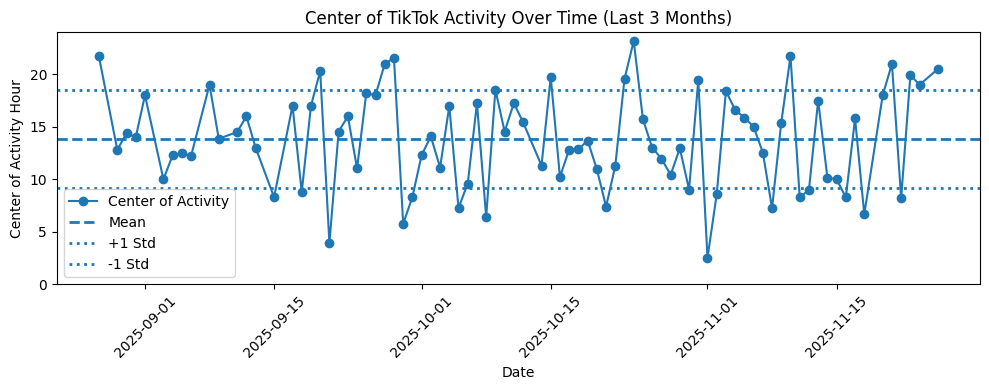

In [ ]:
# 7.4 CENTER OF ACTIVITY- OUTLIER
mean_hour = daily_features["center_of_activity_hour"].mean()
std_hour = daily_features["center_of_activity_hour"].std()
upper_bound = mean_hour + std_hour
lower_bound = mean_hour - std_hour

plt.figure(figsize=(10, 4))
plt.plot(
    daily_features["date"],
    daily_features["center_of_activity_hour"],
    marker='o',
    label="Center of Activity"
)
plt.axhline(mean_hour, linestyle="--", linewidth=2, label="Mean")
plt.axhline(upper_bound, linestyle=":", linewidth=2, label="+1 Std")
plt.axhline(lower_bound, linestyle=":", linewidth=2, label="-1 Std")

plt.xlabel("Date")
plt.ylabel("Center of Activity Hour")
plt.title("Center of TikTok Activity Over Time (Last 3 Months)")
plt.ylim(0, 24)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 8. HYPOTHESIS TESTING

This section applies statistical hypothesis testing to examine whether TikTok usage patterns differ significantly across time periods. The tests aim to support or validate insights observed during the exploratory data analysis.

### 8.1 One-way ANOVA Results and Interpretation

This One-way ANOVA test examines whether the average TikTok usage ratios differ across morning, afternoon, and night periods.

The results show a statistically significant difference between at least one pair of time periods (p-value < 0.05). Therefore, the null hypothesis that all three periods have equal mean usage ratios is rejected.

This result is consistent with the EDA findings and indicates that TikTok usage is not evenly distributed throughout the day.


In [ ]:
# 8-) HYPOTHESIS TESTING

# 8.1 One-way ANOVA: Comparison of Usage Ratios Across Time Periods

from scipy import stats

morning = daily_features["morning_ratio"]
afternoon = daily_features["afternoon_ratio"]
night = daily_features["night_ratio"]

F_stat, p_value = stats.f_oneway(
    morning.dropna(),
    afternoon.dropna(),
    night.dropna()
)

print("One-way ANOVA results (Morning vs Afternoon vs Night)")
print("F-statistic:", round(F_stat, 3))
print("p-value:", round(p_value, 4))

One-way ANOVA results (Morning vs Afternoon vs Night)
F-statistic: 25.876
p-value: 0.0


### 8.2 Paired t-test Results and Interpretation (Morning vs Afternoon)

This paired t-test compares morning and afternoon usage ratios on the same days
to determine whether afternoon usage is significantly different from morning
usage.

The test results show **no statistically significant difference** between
morning and afternoon usage ratios (p-value ≥ 0.05). Therefore, the null
hypothesis cannot be rejected.

Although exploratory analysis suggested slightly higher usage during the
afternoon, this difference is not consistent enough across days to be
statistically meaningful. This indicates a relatively balanced usage pattern
between morning and afternoon periods

In [ ]:
# 8.2 Paired t-test: Comparison of Morning and Afternoon Usage Ratios

from scipy import stats

# Morning ve Afternoon ratio değerleri (aynı günler için)
morning_ratio = daily_features["morning_ratio"]
afternoon_ratio = daily_features["afternoon_ratio"]

# Paired samples t-test
t_stat, p_value = stats.ttest_rel(
    morning_ratio,
    afternoon_ratio,
    nan_policy="omit"
)

print("Paired t-test results (Morning vs Afternoon)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

Paired t-test results (Morning vs Afternoon)
t-statistic: -0.342
p-value: 0.7335


### 8.3 Paired t-test Results and Interpretation (Morning vs Night)

This paired t-test compares morning and night usage ratios on the same days to
examine whether TikTok usage differs significantly between these two periods.

The results indicate a **statistically significant difference** between morning
and night usage ratios (p-value < 0.05). Therefore, the null hypothesis is
rejected.

This finding shows that morning usage is consistently higher than night usage.
Combined with the EDA results, this provides strong evidence against a
night oriented usage pattern and supports a predominantly daytime focused
behavior.


In [ ]:
#8.3 Paired t-test: Comparison of Morning and Night Usage Ratios

from scipy import stats

# Morning ve Afternoon ratio değerleri (aynı günler için)
morning_ratio = daily_features["morning_ratio"]
night_ratio = daily_features["night_ratio"]

# Paired samples t-test
t_stat, p_value = stats.ttest_rel(
    morning_ratio,
    night_ratio,
    nan_policy="omit"
)

print("Paired t-test results (Morning vs Night)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

Paired t-test results (Morning vs Night)
t-statistic: 5.805
p-value: 0.0


### 8.4 Independent t-test Results and Interpretation (Weekend vs Weekday)

This independent t-test compares total TikTok usage intensity (proxy minutes)
between weekend and weekday days to examine whether usage behavior differs
significantly across these two contexts.

The results show **no statistically significant difference** between weekend and
weekday usage levels (p-value ≥ 0.05). Therefore, the null hypothesis cannot be
rejected.

This indicates that TikTok usage intensity remains relatively stable throughout
the week, suggesting that overall usage behavior is not strongly influenced by
whether a day is a weekday or a weekend.


In [ ]:
# 8.4 Independent t-test: Comparison of Weekend and Weekday Usage (Proxy Minutes)

from scipy import stats

weekend_usage = daily_features.loc[
    daily_features["is_weekend"] == True,
    "total_minutes_proxy"
]

weekday_usage = daily_features.loc[
    daily_features["is_weekend"] == False,
    "total_minutes_proxy"
]


t_stat, p_value = stats.ttest_ind(
    weekend_usage,
    weekday_usage,
    nan_policy="omit",
    equal_var=False
)

print("Independent t-test results (Weekend vs Weekday)")
print("t-statistic:", round(t_stat, 3))
print("p-value:", round(p_value, 4))

Independent t-test results (Weekend vs Weekday)
t-statistic: -0.072
p-value: 0.9431


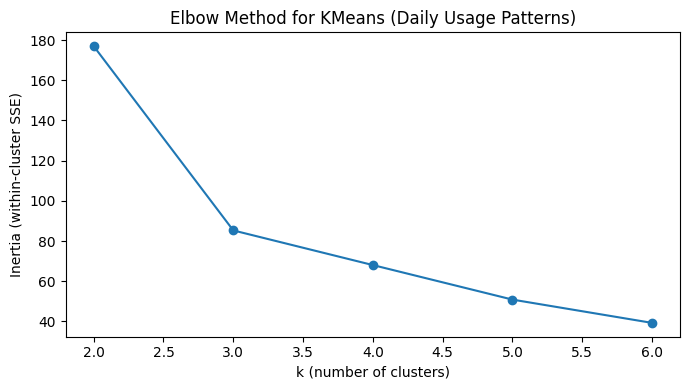

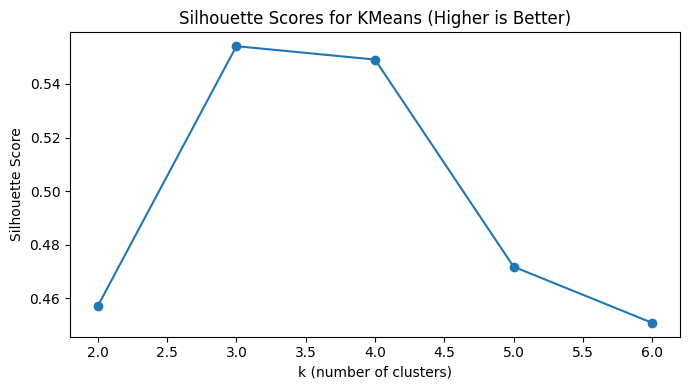

Suggested k by silhouette: 3

Cluster Summary (mean feature values):
         morning_ratio  afternoon_ratio  night_ratio  center_of_activity_hour
cluster                                                                      
0                0.761            0.171        0.069                    9.383
1                0.166            0.789        0.045                   16.204
2                0.231            0.054        0.714                   20.662

Cluster Names (based on dominant ratio):
Cluster 0: Morning-heavy
Cluster 1: Afternoon-heavy
Cluster 2: Night-heavy


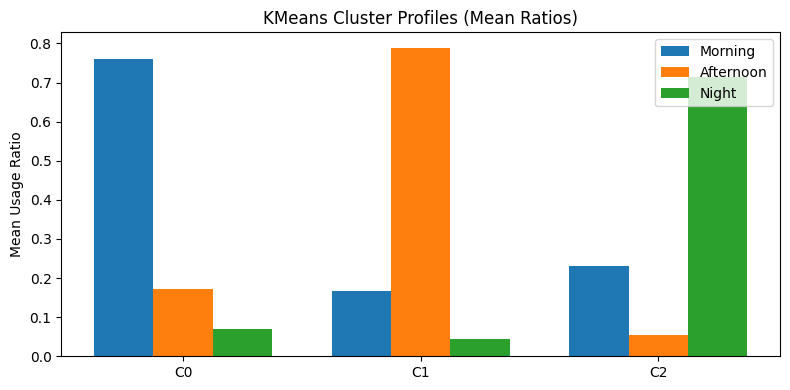

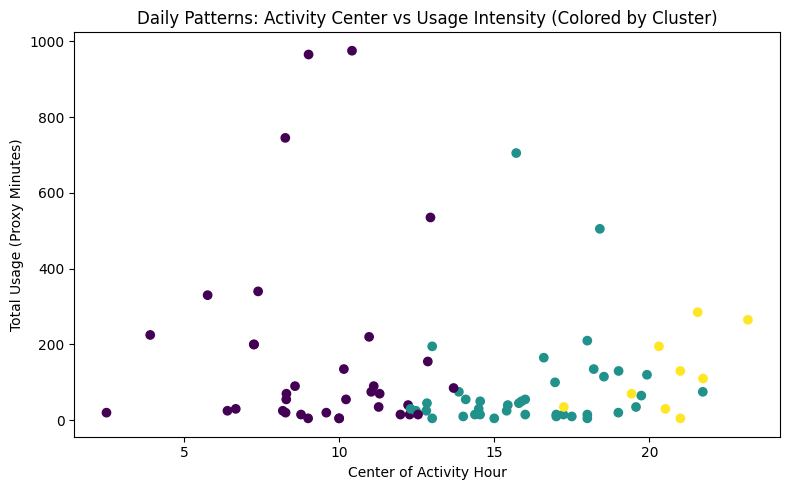


Saved: daily_clusters_kmeans.csv


In [ ]:
# =============================
# 9) MACHINE LEARNING (UNSUPERVISED): K-MEANS CLUSTERING
# =============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# -----------------------------
# 9.1 Feature set (pattern-based)
# We cluster days based on *relative* usage distribution and activity timing.
# Ratios capture preference independent of total daily volume.
# -----------------------------

X = daily_features[[
    "morning_ratio",
    "afternoon_ratio",
    "night_ratio",
    "center_of_activity_hour"
]].dropna().copy()

# Keep the dates aligned for interpretation later
dates_aligned = daily_features.loc[X.index, "date"].values


# -----------------------------
# 9.2 Standardization
# KMeans is distance based; features must be on comparable scales.
# -----------------------------

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# -----------------------------
# 9.3 Choose k
# We evaluate a few k values using inertia (elbow) + silhouette score.
# -----------------------------

k_candidates = [2, 3, 4, 5, 6]
inertias = []
sil_scores = []

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot elbow (inertia)
plt.figure(figsize=(7, 4))
plt.plot(k_candidates, inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for KMeans (Daily Usage Patterns)")
plt.tight_layout()
plt.show()

# Plot silhouette
plt.figure(figsize=(7, 4))
plt.plot(k_candidates, sil_scores, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for KMeans (Higher is Better)")
plt.tight_layout()
plt.show()

# Pick a k
best_k = k_candidates[int(np.argmax(sil_scores))]
print("Suggested k by silhouette:", best_k)


# -----------------------------
# 9.4 Fit final KMeans model
# Use best_k or set manually (commonly 3 for morning/afternoon/night styles).
# -----------------------------

k_final = best_k   # or set manually: 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels back to a results table
clustered_days = X.copy()
clustered_days["date"] = dates_aligned
clustered_days["cluster"] = cluster_labels


# -----------------------------
# 9.5 Cluster profiles (what each cluster means)
# We summarize the average ratios + center hour for each cluster.
# -----------------------------

cluster_summary = (
    clustered_days
    .groupby("cluster")[["morning_ratio", "afternoon_ratio", "night_ratio", "center_of_activity_hour"]]
    .mean()
    .sort_index()
)

print("\nCluster Summary (mean feature values):")
print(cluster_summary.round(3))


# -----------------------------
# 9.6 Simple interpretation helper: auto name clusters
# -----------------------------

def label_cluster(row):
    ratios = {
        "Morning-heavy": row["morning_ratio"],
        "Afternoon-heavy": row["afternoon_ratio"],
        "Night-heavy": row["night_ratio"]
    }
    return max(ratios, key=ratios.get)

cluster_names = cluster_summary.apply(label_cluster, axis=1).to_dict()
clustered_days["cluster_name"] = clustered_days["cluster"].map(cluster_names)

print("\nCluster Names (based on dominant ratio):")
for c in sorted(cluster_names.keys()):
    print(f"Cluster {c}: {cluster_names[c]}")


# -----------------------------
# 9.7 Visualization: Cluster profile bars (mean ratios)
# -----------------------------

# Mean ratios by cluster
ratios_by_cluster = cluster_summary[["morning_ratio", "afternoon_ratio", "night_ratio"]]

plt.figure(figsize=(8, 4))
x = np.arange(len(ratios_by_cluster.index))
width = 0.25

plt.bar(x - width, ratios_by_cluster["morning_ratio"], width, label="Morning")
plt.bar(x,         ratios_by_cluster["afternoon_ratio"], width, label="Afternoon")
plt.bar(x + width, ratios_by_cluster["night_ratio"], width, label="Night")

plt.xticks(x, [f"C{c}" for c in ratios_by_cluster.index])
plt.ylabel("Mean Usage Ratio")
plt.title("KMeans Cluster Profiles (Mean Ratios)")
plt.legend()
plt.tight_layout()
plt.show()


# -----------------------------
# 9.8 Visualization:
# -----------------------------

tmp = daily_features.loc[X.index, ["total_minutes_proxy"]].copy()
clustered_days["total_minutes_proxy"] = tmp["total_minutes_proxy"].values

plt.figure(figsize=(8, 5))
plt.scatter(
    clustered_days["center_of_activity_hour"],
    clustered_days["total_minutes_proxy"],
    c=clustered_days["cluster"],
)
plt.xlabel("Center of Activity Hour")
plt.ylabel("Total Usage (Proxy Minutes)")
plt.title("Daily Patterns: Activity Center vs Usage Intensity (Colored by Cluster)")
plt.tight_layout()
plt.show()


# -----------------------------
# 9.9 Save results
# -----------------------------
clustered_days = clustered_days.sort_values("date")
clustered_days.to_csv("daily_clusters_kmeans.csv", index=False)
print("\nSaved: daily_clusters_kmeans.csv")
